# A5

In [39]:
# Standard Imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import Network as NN
import importlib
import mnist_loader

import copy
import random

# Q1: Electrophysiology Experiment

In [15]:
import lif

def MonkeyFixationSpikes(x, T, pop):
    """
    spike_times = MonkeyFixationSpikes(x, T, pop)

    Given the gaze direction, outputs the spiking activity of the monkey's
    neurons.

    Input:
      x is the monkey's gaze direction
      T is the duration of the fixation (in seconds)
      pop is a 6xN matrix of LIF parameters

    Output:
      spike_times is an list containing N arrays of time-stamps indicating
        when each neuron fired.  
    """
    dt = 0.001  # time-step size for simulations
    xts = x*np.ones(int(T/dt))
    sp, v = lif.Stim2Spikes(xts, dt, pop, interp=True)
    return sp

In [16]:
#=====================
# CHOOSE A MONKEY
# The monkey's are numbered 0, 1, 2, 3, and 4.
# This will read in the LIF parameters for the monkey's neurons
# as well as the spiking trains for the unknown sequence.
#=====================
infile = open('monkey3.npz', 'rb')
varsin = np.load(infile)
pop = varsin['pop']   # parameters for population of neurons
Asp = varsin['Asp']   # spike trains for unknown sequence
N = len(pop[1])  # number of neurons

## (a) Behavioural Sampling Experiment

In [17]:
# Select a spread of stimulus values from 0 to 9. Choose at least 100 samples.
gaze_dir = np.linspace(0,10, 100)
T= 0.4
A = np.zeros((100,40))
index = 0;
for x in gaze_dir:
    sp = MonkeyFixationSpikes(x, T, pop)
    for i in range(N):
        A[index][i] = len(sp[i])/0.4
    index +=1

## (b) View Tuning Curves

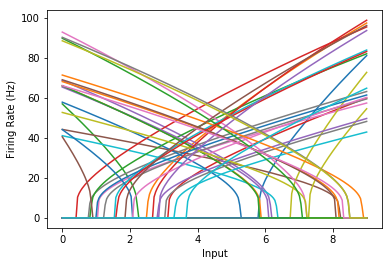

In [18]:
lif.PlotTuningCurves(pop,xlim=[0, 9])

## (c) Compute the Decoding Weights

In [19]:
D = np.dot(np.linalg.inv(np.dot(A.T, A)), A.T)
D = np.dot(D, gaze_dir)

## (d) View Spike Raster of Unknown Sequence

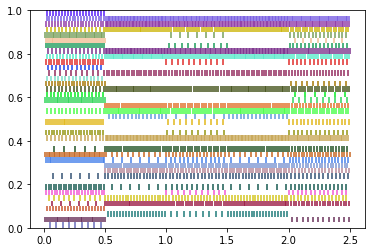

In [20]:
lif.PlotSpikeRaster(Asp)

## (e) Decode the Unknown Code

In [21]:
# Spike trains for unknown sequence are stored in 'Asp'
# Asp is a list of arrays of spike trains, one array per neuron.

In [22]:
# Compute firing rates
gaze_direction = 0
frs = np.zeros((5, 40))
for i in range(5):
    arr = lif.CountSpikes(Asp, i*0.5, (i+1)*0.5)
    for neuron in range(len(arr)):
        frs[i][neuron] = arr[neuron]/0.5

In [23]:
# Decode unknown code
gaze_direction= np.dot(frs,D)

## (f) Display the Unknown Code

Text(0, 0.5, 'gaze dierection')

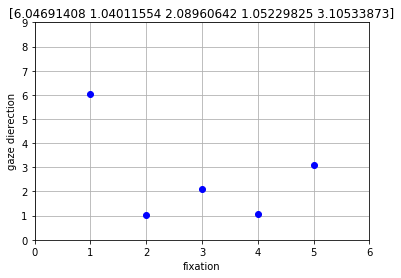

In [77]:
plt.axis([0,6,0,9])
plt.grid(True)
plt.plot(range(1,6),gaze_direction, 'bo')
plt.title(gaze_direction)
plt.xlabel('fixation')
plt.ylabel('gaze dierection')

# Q2: LSTM

In [59]:
# You may include some Python code to help you.
def tanh(x):
    return np.exp(x) - np.exp(-x) / np.exp(x) + np.exp(-x)

def Ct_ht(W,b, W_c,v,b_c,C_t_1):
    matrix = 1 / (1 + np.exp(-(np.dot(W,v) + b)))
    f_t = matrix[0]
    i_t = matrix[1]
    o_t = matrix[2]
    C_t = f_t * C_t_1 + tanh(np.dot(W_c,v) + b_c) * i_t
    h_t = o_t * tanh(C_t)
    return C_t[0], h_t[0], f_t, i_t, o_t

## (a)

### (i)

In [65]:
# You can include some code, if you want.
W = np.array([[0,8,0,0],[0,0,9,0],[0,0,0,10]])
b = np.array([-4,-4.5,-5])
W_c = np.array([1,0,0,0])
v =np.array([0.05,1,0,0])
b_c = np.array([0])
C_t_1 = np.array([-0.02])

C_t,h_t, f_t,i_t,o_t = Ct_ht(W,b,W_c,v,b_c,C_t_1)
print('value of gates:')
print('f_t: '+str(f_t) + ',i_t:'+str(i_t)+',o_t:'+str(o_t)+',C_t:'+ str(C_t)+',h_t:'+ str(h_t))

value of gates:
f_t: 0.9820137900379085,i_t:0.01098694263059318,o_t:0.0066928509242848554,C_t:-0.007580314262127635,h_t:0.006590994618738412


Since forget_gate stores the most of cell while input and output gates are inactivated, $C_t$ is similar to $C_{t-1}$.

### (ii)

In [66]:
C_t,h_t, f_t,i_t,o_t = Ct_ht(W,b,W_c, np.array([0.05,0,1,0]),b_c,C_t_1)
print('value of gates:')
print('f_t: '+str(f_t) + ',i_t:'+str(i_t)+',o_t:'+str(o_t)+',C_t:'+ str(C_t)+',h_t:'+ str(h_t))

value of gates:
f_t: 0.01798620996209156,i_t:0.9890130573694068,o_t:0.0066928509242848554,C_t:1.0852434171029062,h_t:0.021309085516791674


Since input gate approaches 1, $C_t$ is similar to $C_{t-1}$. 

### (iii)

In [67]:
C_t,h_t, f_t,i_t,o_t = Ct_ht(W,b,W_c, np.array([0.05,1,0,1]),b_c,C_t_1)
print('value of gates:')
print('f_t: '+str(f_t) + ',i_t:'+str(i_t)+',o_t:'+str(o_t)+',C_t:'+ str(C_t)+',h_t:'+ str(h_t))

value of gates:
f_t: 0.9820137900379085,i_t:0.01098694263059318,o_t:0.9933071490757153,C_t:-0.007580314262127635,h_t:0.9781903329950504


Since $C_t$'s forget_gate approaches 1, $C_t$ is similar to $C_{t-1}$.
Similarly, $C_t$ and $C_{t-1}$ are almost the same since the output gate approaches 1.

## (b)

In [68]:
print ("Assign xt to be [1,1,1]")
C_t,h_t, f_t,i_t,o_t = Ct_ht(W,b,W_c, np.array([0.05,1,1,1]),b_c,C_t_1)
print('check value of gates:')
print('f_t: '+str(f_t) + ',i_t:'+str(i_t)+',o_t:'+str(o_t)+',C_t:'+ str(C_t)+',h_t:'+ str(h_t))

Assign xt to be [1,1,1]
check value of gates:
f_t: 0.9820137900379085,i_t:0.9890130573694068,o_t:0.9933071490757153,C_t:1.06596286550139,h_t:3.1084761221705155


YOUR ANSWER HERE.

## (c)

In [69]:
print ("Assign xt to be [1/2,1/2,1/2]")
C_t,h_t, f_t,i_t,o_t = Ct_ht(W,b,W_c, np.array([0.05,1/2,1/2,1/2]),b_c,C_t_1)
print('check value of gates:')
print('f_t: '+str(f_t) + ',i_t:'+str(i_t)+',o_t:'+str(o_t)+',C_t:'+ str(C_t)+',h_t:'+ str(h_t))

Assign xt to be [1/2,1/2,1/2]
check value of gates:
f_t: 0.5,i_t:0.5,o_t:0.5,C_t:0.5388315514203893,h_t:0.9785212377952108


YOUR ANSWER HERE.

# Q3: Adversarial Inputs

## Load data, get trained network, etc.

In [40]:
# Load MNIST
train, validate, test = mnist_loader.load_data_wrapper()
train_in = np.array(train[0])
train_out = np.array(train[1])

In [41]:
# Or, you can load the pretrained Network object from the supplied file,
# like this...
net = NN.Network()
net.Load('MNIST_trained_784-100-100-10.npy')

In [70]:
test_ac = NN.ClassificationAccuracy(net.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')

train_ac = NN.ClassificationAccuracy(net.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')

TypeError: ClassificationAccuracy() missing 1 required positional argument: 'targets'

In [71]:
#Extract 10 digits from MNIST classified correctly by the network
x_image = []
x_class = []
for i in range(0, 10):
    while True:
        j = random.randint(0, len(test[0]))
        if np.argmax(test[1][j]) == i:
            r = net.FeedForward([test[0][j]])
            if np.argmax(r) == i:
                x_image.append(test[0][j])
                x_class.append(test[1][j])
                break

## (a) GradientInput

In [72]:
def GradientInput(net, x, t):
    '''
        dEdx = Input_Gradient_Ascent(net, x, t)

        Computes dEdx for a network given input x and target t.
        The cost function is specified by the network.

        Inputs:
          net is the neural network
          x is the input that you want to perturb
          t is the corresponding true target vector (one-hot)
        
        Output:
          dEdx is a vector the same shape as x
    '''

    t = np.array(t)  # convert t to an array, in case it's not
    net.FeedForward(x)
    # Error gradient for top layer
    dEdz = net.TopGradient(t) 

    # Loop down through the layers
    for i in range(net.n_layers-2, -1, -1):
        pre = net.lyr[i]

        # Gradient w.r.t. weights
        dEdW = pre.h.T @ dEdz

        # Gradient w.r.t. biases
        dEdb = np.sum(dEdz, axis=0)

        # If not the bottom layer,
        # Project error gradient down to layer below
        if i>0:
            dEdz = ( dEdz @ net.W[i].T ) * pre.sigma_z_p(pre.z)
    
    dEdx = dEdz @ net.W[0].T
    return dEdx

## (b) FGSM

In [73]:
def FGSM(net, x_input, x_class, ep=0.05, it_lim=100000, conf=0.5, targ=False):
    '''
        x_adv = FGSM(x_input, x_class, ep=0.05, it_lim=100000, conf=0.5)
        
        Performs the Fast Gradient Sign Method, perturbing each input until it
        is misclassified with the specified confidence, or reaches the maximum
        number of iterations.
        
        Inputs:
          net is the Network object
          x_input is a batch of inputs
          x_class is the corresponding one-hot class vectors
          ep is the perturbation step for the FGSM
          it_lim is the maximum number of iterations
          conf is the desired confidence for the misclassification
          targ is Boolean, indicating if the FGSM is targetted
             if targ is False, then x_class is considered to be the true
             class of the input, and FGSM will work to increase the cost
             if targ is True, then x_class is considered to be the target
             class for the perturbation, and FGSM will work to decrease the cost
        
        Output:
          x_adv is a batch of adversarial inputs, the same size as x_input
    '''
    iterator = 0;
    truevalue = np.argmax(x_class)
    if targ ==False:
        while True:
            inputGradient = GradientInput(net, x_input, x_class)
            x_input += ep* np.sign(inputGradient[0])
            iterator +=1
            output = net.FeedForward(x_input)[0]
            maxindex = np.argmax(output)
            if (maxindex != truevalue and output[maxindex] >= conf) or iterator >= it_lim:
                break
        
    else:
        while True:
            inputGradient = GradientInput(net, x_input, x_class)
            x_input -= ep* np.sign(inputGradient[0])
            iterator +=1
            output = net.FeedForward(x_input)[0]
            maxindex = np.argmax(output)
            if (maxindex == truevalue and output[maxindex] >= conf) or iterator >= it_lim:
                break
    
    return x_input

## (c) Untargetted Adversarial Perturbation

digit 0 classified as 9 with classification value 0.9996437937391601
digit 1 classified as 8 with classification value 0.999958272487497
digit 2 classified as 3 with classification value 0.9999950498255294
digit 3 classified as 5 with classification value 0.9999980621483041
digit 4 classified as 2 with classification value 0.9996633798078722
digit 5 classified as 3 with classification value 0.9999865288568199
digit 6 classified as 2 with classification value 0.9999968824240781
digit 7 classified as 3 with classification value 0.9998479951353728
digit 8 classified as 0 with classification value 0.9969903987788724
digit 9 classified as 4 with classification value 0.9998450914819013


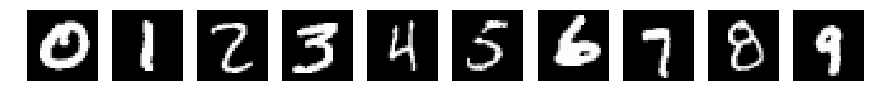

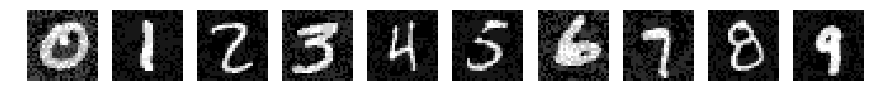

In [74]:
mynet = NN.Network()
mynet.Load('MNIST_trained_784-100-100-10.npy')
adver = []
for i in range(10):
    nparr = FGSM(net=mynet, x_input= [x_image[i]], x_class= x_class[i])
    adver.append(nparr)
# Display some sample digit images
plt.figure(figsize=[15,4])
for n in range(10):
    plt.subplot(1,10,n+1)
    plt.imshow(np.reshape(x_image[n], [28,28]), cmap='gray'); plt.axis('off');
plt.figure(figsize=[15,4])
for n in range(10):
    plt.subplot(1,10,n+1)
    plt.imshow(np.reshape(adver[n], [28,28]), cmap='gray'); plt.axis('off');
for i in range(10):
    output = mynet.FeedForward([adver[i]])
    value = np.argmax(output)
    accuracy = np.amax(output)
    print('digit ' + str(i) + ' classified as '+ str(value) + ' with classification value '+ str(accuracy))

## (d) Targetted Adversarial Perturbation

digit 5 classified as 3 with classification value 0.9991105761754594
digit 1 classified as 0 with classification value 0.9670989484568269
digit 7 classified as 6 with classification value 0.9954126547297767


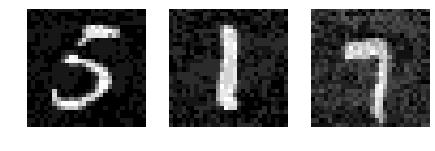

In [75]:
def makeonehot(i):
    arr = np.zeros(10)
    arr[i] = 1
    return arr
mynet = NN.Network()
mynet.Load('MNIST_trained_784-100-100-10.npy')

def PrintAccuracy(num1, num2, adver):
    nparr = FGSM(net=mynet, x_input= [x_image[num1]], x_class= makeonehot(num2), conf=0.8, targ=True)
    output = mynet.FeedForward([nparr])
    value = np.argmax(output)
    accuracy = np.amax(output)
    print('digit ' + str(num1) + ' classified as '+ str(num2) + ' with classification value '+ str(accuracy))
    adver.append(nparr)
    return adver

#print accuracy
adver=[]
PrintAccuracy(5, 3, adver)
PrintAccuracy(1, 0, adver)
PrintAccuracy(7, 6, adver)
#print perturbed image
plt.figure(figsize=[25,4])
for n in range(len(adver)):
    plt.subplot(1,10,n+1)
    plt.imshow(np.reshape(adver[n], [28,28]), cmap='gray'); plt.axis('off');
    